In [1]:
import numpy as np
from numpy.fft import fft2, ifft2
import scipy as sp
import sigpy
import sigpy.mri as mr
import sigpy.plot as pl
import matplotlib.pyplot as plt
import pywt
import sys
sys.path.append('/home/batman/Documents/ma221/gfloat/src')
import gfloat
from gfloat.formats import *
from gfloat import decode_float

/home/batman/anaconda3/envs/fp8/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


kspace: (8, 230, 180) complex64


EspiritCalib: 100%|██████████| 100/100 [00:00<00:00, 162.27it/s]


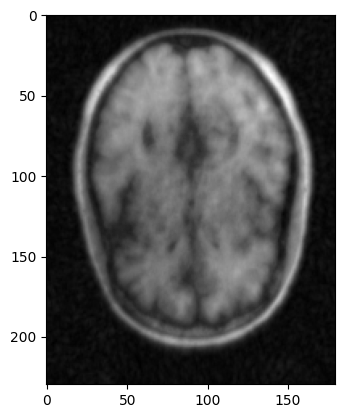

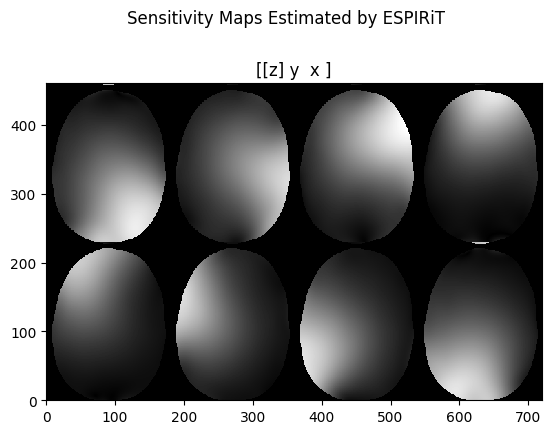

Sensitivity maps: (8, 230, 180) complex64


In [2]:
ksp_path = "/home/batman/Documents/sigpy_tutorial/sigpy-mri-tutorial/data/"
ksp = np.load(ksp_path + 'cartesian_ksp.npy')
print('kspace:', ksp.shape, ksp.dtype)



img_mc = np.abs(sigpy.ifft(ksp, axes=(-1, -2))) # image space multicoil
img_rss = np.sum(img_mc**2, axis=0)**0.5
plt.imshow(img_rss, cmap='gray')

# get smaps
mps = mr.app.EspiritCalib(ksp).run()
pl.ImagePlot(mps, z=0, title='Sensitivity Maps Estimated by ESPIRiT')
print('Sensitivity maps:', mps.shape, mps.dtype)

#### Sigpy TV recon test

MaxEig:   3%|▎         | 1/30 [00:00<00:00, 42.38it/s, max_eig=9.19E+02]

TotalVariationRecon: 100%|██████████| 100/100 [00:02<00:00, 42.63it/s, resid=9.93E-02]


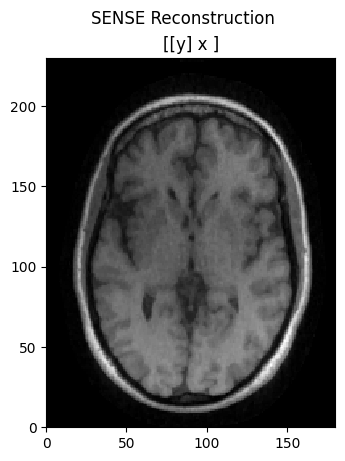

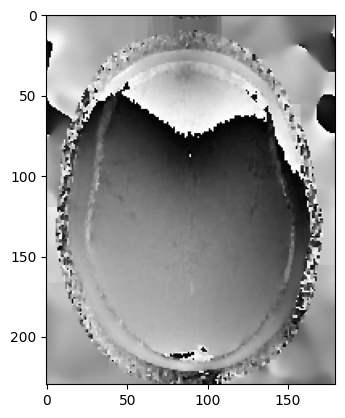

In [6]:
lamda = 1e-3
# 32 bit
img_sense = mr.app.TotalVariationRecon(ksp, mps, lamda=lamda, solver='PrimalDualHybridGradient', max_iter=100).run()

pl.ImagePlot(img_sense, title='SENSE Reconstruction')
plt.imshow(np.flip(np.angle(img_sense)), cmap='gray')

#### naive implementaiton

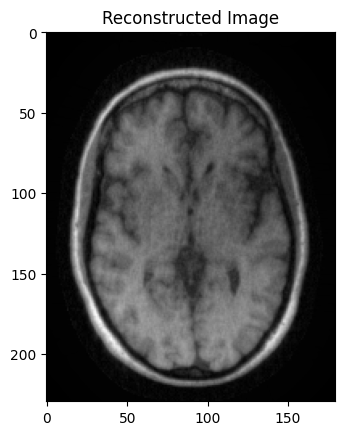

In [43]:
def fft2c(x):
    """Centered 2D FFT."""
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x, axes=(-2,-1)), norm='ortho'), axes=(-2,-1))

def ifft2c(x):
    """Centered 2D IFFT."""
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(x, axes=(-2,-1)), norm='ortho'), axes=(-2,-1))

def forward_A(x, mps, mask):
    """
    Forward operator A: x -> y
    x: (h, w) complex image
    mps: (num_coils, h, w) coil sensitivity maps
    mask: (h, w) boolean mask indicating sampled k-space locations
    Returns: (num_coils, h, w) k-space data
    """
    # Coil sensitivity weighting
    coil_imgs = mps * x[np.newaxis, ...]  # shape: (num_coils, h, w)
    # Fourier transform
    coil_kspace = fft2c(coil_imgs)
    # Apply mask
    coil_kspace_masked = coil_kspace * mask
    return coil_kspace_masked

def adjoint_A(y, mps, mask):
    """
    Adjoint operator A^H: y -> x
    y: (num_coils, h, w) k-space data
    mps: (num_coils, h, w) coil sensitivity maps
    mask: (h, w) boolean mask
    Returns: (h, w) complex image
    """
    # Apply mask
    y_filled = y * mask
    # Inverse Fourier transform
    coil_imgs = ifft2c(y_filled)
    # Combine coils
    x = np.sum(coil_imgs * np.conjugate(mps), axis=0)
    return x

def forward_G(x):
    """
    Finite differences operator G: x -> Gx
    x: (h, w)
    Returns: (2, h, w) where Gx[0] = diff along width, Gx[1] = diff along height
    Uses forward differences with periodic boundary conditions.
    """
    h, w = x.shape
    Gx = np.zeros((2, h, w), dtype=x.dtype)
    # Horizontal difference: along w-axis
    Gx[0, :, :] = x[:, np.roll(np.arange(w), -1)] - x
    # Vertical difference: along h-axis
    Gx[1, :, :] = x[np.roll(np.arange(h), -1), :] - x
    return Gx

def adjoint_G(u):
    """
    Adjoint of G: u -> G^H u
    u: (2, h, w)
    Returns: (h, w)
    """
    # If Gx[0, i, j] = x[i,j+1]-x[i,j], adjoint sums differences in the opposite direction.
    # adjoint along horizontal dimension:
    h, w = u.shape[1], u.shape[2]
    ux = u[0]
    uy = u[1]
    # For ux: sum differences reversed
    # if ux[i,j] = x[i, j+1]-x[i,j], then adjoint accumulates (-ux[i,j] + ux[i,j-1])
    x_grad = ux - ux[:, np.roll(np.arange(w), 1)]
    y_grad = uy - uy[np.roll(np.arange(h), 1), :]
    return x_grad + y_grad

def l1_prox(u, lam, sigma):
    """
    Proximal operator for L1 norm: prox_{sigma * lambda * ||·||_1}(u).
    Soft-thresholding: u -> u * max(1 - sigma*lam/|u|, 0)
    Here u can be complex. Use the L2 norm across the channel dimension if needed.
    For TV, we apply the threshold componentwise.
    """
    # Compute magnitude
    mag = np.abs(u)
    # Avoid division by zero
    threshold = lam * sigma
    # Soft threshold
    return np.where(mag > threshold, u * (1 - threshold/mag), 0)

def pdhg_recon(y, mps, lam, max_iter=100, tol=1e-6):
    """
    Perform TV-regularized reconstruction using PDHG.

    Inputs:
        y: (num_coils, h, w) undersampled k-space data
        mps: (num_coils, h, w) coil sensitivities
        lam: regularization parameter (lambda)
    Returns:
        x: (h, w) reconstructed image
    """

    # Extract shapes
    num_coils, h, w = mps.shape
    # Derive a mask from y (assuming zero-filled for undersampling)
    mask = (np.abs(y) > 0).any(axis=0)  # If at least one coil samples that point.
    # For simplicity, use the same mask for all coils (typical scenario)
    mask = mask[np.newaxis, ...]  # shape (1, h, w), broadcast along coils

    # Initial guess for x
    x = np.zeros((h, w), dtype=np.complex128)
    x_bar = x.copy()  # extrapolated primal variable

    # Dual variable: u corresponds to the concatenation of f*(u) and TV dual variable
    # For the classical formulation:
    # We have dual variable for the data-fitting term (already included by A and prox_f^*)
    # and for the TV term. However, we can stack them in a unified approach.
    # For simplicity, we will separate them here:
    # u_f: same shape as y (data fidelity dual)
    u_f = np.zeros_like(y)
    # u_g: same shape as Gx = (2, h, w)
    u_g = np.zeros((2, h, w), dtype=np.complex128)

    # Step sizes:
    # A rough heuristic: 
    # Norm of A ~ sqrt(num_coils), norm of G ~ 4 (for finite differences)
    # We'll pick sigma and tau to satisfy sigma * tau * (|A|^2 + |G|^2) < 1
    # This is a heuristic; one can be more careful or use power iterations as sigpy does.
    sigma = 1.0
    tau = 0.5e-1  # smaller step to ensure convergence

    # PDHG iteration:
    # Problem: min_x f(Ax) + g(x) where f = 1/2||Ax - y||_2^2 and g = lam * ||Gx||_1
    # In primal-dual form:
    #   L(x, u) = g(x) + <Ax, u_f> - f^*(u_f) + ... similarly for u_g and g.

    # Here f = 1/2||Ax - y||_2^2, f^*(u_f) = 1/2||u_f + y||_2^2 - ...
    # Instead of directly using f^*, we can incorporate the prox step for the dual variable.

    # For the TV part (g = lam*||Gx||_1), its conjugate g^* is indicator of max-norm <= lam.
    # The prox of g is done on the primal side as a simple no-op in this scheme, and we do prox_g on u_g.

    # We'll follow the standard PDHG update steps:
    # Dual update (u):
    #   u_f <- prox_{f^*}(u_f + sigma*A*x_bar)
    #   u_g <- prox_{g^*}(u_g + sigma*G*x_bar)
    #
    # Primal update (x):
    #   x_old = x
    #   x <- prox_g(x - tau*A^H(u_f) - tau*G^H(u_g))
    #   x_bar = x + theta*(x - x_old) with theta=1 usually

    # Define prox_f^*(sigma, u_f):
    # For f(x) = 1/2||Ax - y||_2^2, f^*(u_f) = sup_{z} <z, u_f> - f(z)
    # The prox of f^* with parameter sigma is:
    #   prox_{f^*}(u_f) = (u_f - sigma*y)/(1 + sigma)
    # Derivation: f^*(u_f) = ... leads to the Moreau identity, or from PDHG standard forms.
    # Actually, from PDHG perspective:
    #   f(Ax) = 1/2||Ax - y||_2^2,
    #   f^*(u_f) = sup_x <Ax, u_f> - 1/2||Ax - y||_2^2
    # The proximal operator:
    #   prox_{f^*}(u_f, sigma) = (u_f - sigma*y)/(1 + sigma)
    #
    # For g^* (TV):
    #   g(x) = lam ||Gx||_1
    #   g^*(u_g) = 0 if |u_g|_inf <= lam (componentwise), else infinity
    # prox_{g^*}(u_g, sigma=1 actually since we incorporate sigma inside) = projection onto ||u_g||_inf <= lam
    # Actually the prox of g^* is a projection step:
    #   prox_{g^*}(u_g, sigma) = u_g / max(1, |u_g|/lam)
    # where |u_g| is pointwise magnitude.

    def prox_fstar(u_f, sigma):
        return (u_f - sigma * y) / (1 + sigma)

    def prox_gstar(u_g, lam):
        # Project u_g onto the L-infinity ball of radius lam
        # For TV: lam is the regularization parameter, we must ensure dual variable satisfies |u_g(i)| <= lam
        mag = np.sqrt(np.sum(np.abs(u_g)**2, axis=0))
        # If mag > lam, scale down
        # Broadcast scale factor
        scale = np.maximum(1.0, mag / lam)
        scale = scale[np.newaxis, :, :]  # shape (1, h, w)
        return u_g / scale

    theta = 1.0
    for i in range(max_iter):
        x_old = x.copy()

        # Dual update
        # u_f
        u_f = prox_fstar(u_f + sigma * forward_A(x_bar, mps, mask), sigma)

        # u_g
        u_g = u_g + sigma * forward_G(x_bar)
        u_g = prox_gstar(u_g, lam)

        # Primal update
        # Gradient step
        grad_data = adjoint_A(u_f, mps, mask)  # AH u_f
        grad_tv = adjoint_G(u_g)               # G^H u_g
        x = x - tau * (grad_data + grad_tv)
        # prox_g on primal is identity since we separated g into dual variable part
        # If we had a non-trivial prox_g, we would apply it here.

        # Extrapolation
        x_bar = x + theta * (x - x_old)

        # Check convergence
        # Use primal variable difference as a heuristic
        diff_norm = np.linalg.norm(x - x_old)
        if diff_norm < tol:
            print(f"Converged at iteration {i}")
            break

    return x

if __name__ == "__main__":

    # Set lambda
    lam = 1e-3
    # Run reconstruction
    x_naive = pdhg_recon(ksp, mps, lam, max_iter=100, tol=1e-7)
    plt.imshow(np.flip(np.abs(x_naive)), cmap='gray')
    plt.title("Reconstructed Image")
    plt.show()

#### FP8 implementaiton

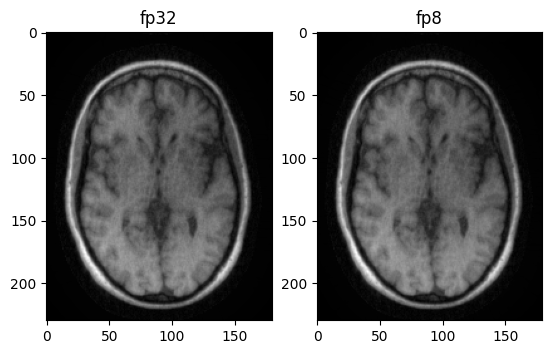

False


In [42]:
# FP8 simulated arithmetic helper functions
def fp8_add(a, b, fp8_format):
    # Convert inputs to FP8 if not already (assume they are already FP8 for simplicity).
    # Perform addition in double precision
    c = a + b
    # Quantize result back to FP8
    c_fp8 = to_fp8(c, fp8_format)
    return c_fp8

def fp8_sub(a, b, fp8_format):
    c = a - b
    c_fp8 = to_fp8(c, fp8_format)
    return c_fp8

def fp8_roll(x, shift, axis, fp8_format):
    # Roll in double precision then quantize
    xr = np.roll(x, shift, axis=axis)
    xr_fp8 = to_fp8(xr, fp8_format)
    return xr_fp8

def to_fp8(x, format):
    fp8_real = gfloat.round_ndarray(format, x.real)
    fp8_imag = gfloat.round_ndarray(format, x.imag)
    fp8_complex = fp8_real + 1j * fp8_imag
    return fp8_complex

def fft2c(x):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x, axes=(-2,-1)), norm='ortho'), axes=(-2,-1))

def ifft2c(x):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(x, axes=(-2,-1)), norm='ortho'), axes=(-2,-1))

def forward_A(x, mps, mask):
    # Keep these in higher precision (FP16/FP32)
    coil_imgs = mps * x[np.newaxis, ...]
    coil_kspace = fft2c(coil_imgs)
    coil_kspace_masked = coil_kspace * mask
    return coil_kspace_masked

def adjoint_A(y, mps, mask):
    # Keep in higher precision
    y_filled = y * mask
    coil_imgs = ifft2c(y_filled)
    x = np.sum(coil_imgs * np.conjugate(mps), axis=0)
    return x

def forward_G(x, fp8_format):
    # Emulate FP8 operations:
    # Steps:
    # 1. Convert x to FP8
    x_fp8 = to_fp8(x, fp8_format)
    h, w = x.shape

    # Compute Gx in FP8:
    # Gx[0,i,j] = x[i, j+1] - x[i,j]
    # Gx[1,i,j] = x[i+1, j] - x[i,j]

    # Roll indices in FP8:
    rolled_w_fp8 = fp8_roll(x_fp8, -1, 1, fp8_format)  # x[:, j+1]
    rolled_h_fp8 = fp8_roll(x_fp8, -1, 0, fp8_format)  # x[i+1, :]

    # Subtractions in FP8:
    gx0_fp8 = fp8_sub(rolled_w_fp8, x_fp8, fp8_format)
    gx1_fp8 = fp8_sub(rolled_h_fp8, x_fp8, fp8_format)

    # Stack results:
    Gx_fp8 = np.stack([gx0_fp8, gx1_fp8], axis=0)

    return Gx_fp8

def adjoint_G(u, fp8_format):
    # u is (2, h, w)
    # Emulate FP8 operations again:
    # Convert u to FP8
    u_fp8 = to_fp8(u, fp8_format)
    ux_fp8 = u_fp8[0]
    uy_fp8 = u_fp8[1]

    h, w = ux_fp8.shape

    # For adjoint:
    # G^H(u)[i,j] = (u[0,i,j] - u[0,i,j-1]) + (u[1,i,j] - u[1,i-1,j])
    # Carefully do these in FP8.

    # Roll back:
    ux_roll_fp8 = fp8_roll(ux_fp8, 1, 1, fp8_format) # u[0,i,j-1]
    uy_roll_fp8 = fp8_roll(uy_fp8, 1, 0, fp8_format) # u[1,i-1,j]

    # Perform subtractions in FP8:
    diff_x_fp8 = fp8_sub(ux_fp8, ux_roll_fp8, fp8_format)
    diff_y_fp8 = fp8_sub(uy_fp8, uy_roll_fp8, fp8_format)

    # Add them together in FP8:
    x_grad_fp8 = fp8_add(diff_x_fp8, diff_y_fp8, fp8_format)

    return x_grad_fp8

def prox_fstar(u_f, sigma, y):
    # Keep in FP16/FP32
    return (u_f - sigma * y) / (1 + sigma)

def prox_gstar(u_g, lam, fp8_format):
    # Elementwise projection in FP8:
    # Convert to FP8 if not already
    u_g_fp8 = to_fp8(u_g, fp8_format)
    mag = np.sqrt(np.sum(np.abs(u_g_fp8)**2, axis=0))
    scale = np.maximum(1.0, mag / lam)
    scale = scale[np.newaxis, :, :]

    # scale the FP8 array:
    scaled_u_g = u_g_fp8 / scale
    scaled_u_g_fp8 = to_fp8(scaled_u_g, fp8_format)
    return scaled_u_g_fp8

def pdhg_recon(y, mps, lam, max_iter=100, tol=1e-6, fp8_format=None):
    num_coils, h, w = mps.shape
    mask = (np.abs(y) > 0).any(axis=0)
    mask = mask[np.newaxis, ...] 

    x = np.zeros((h, w), dtype=np.complex64)
    x_bar = x.copy()

    u_f = np.zeros_like(y)
    u_g = np.zeros((2, h, w), dtype=np.complex64)

    sigma = 1.0
    tau = 0.05
    theta = 1.0

    for i in range(max_iter):
        x_old = x.copy()

        # Dual update f:
        u_f = prox_fstar(u_f + sigma * forward_A(x_bar, mps, mask), sigma, y)

        # Dual update g in FP8:
        Gx_bar_fp8 = forward_G(x_bar, fp8_format)
        u_g_fp8 = to_fp8(u_g, fp8_format)
        # u_g <- u_g + sigma*Gx_bar in FP8
        u_g_fp8 = fp8_add(u_g_fp8, sigma * Gx_bar_fp8, fp8_format)
        # prox_gstar in FP8
        u_g_fp8 = prox_gstar(u_g_fp8, lam, fp8_format)
        u_g = u_g_fp8  # Now u_g is in FP8 quantized form.

        # Primal update:
        grad_data = adjoint_A(u_f, mps, mask)  # FP16/FP32
        # adjoint_G in FP8:
        grad_tv_fp8 = adjoint_G(u_g, fp8_format)
        # grad_tv_fp8 is in FP8; convert to FP16/FP32 for the final x update:
        # Since we need stable updates, let's convert back to a higher precision:
        # We don't have from_fp8, but let's assume to_fp8 gives us a NumPy array in normal precision (just quantized).
        # If it's still complex128 with quantized values, we can proceed:
        grad_tv = grad_tv_fp8  # Here it's still a NumPy array, just quantized values.

        x = x - tau * (grad_data + grad_tv)
        x_bar = x + theta * (x - x_old)

        diff_norm = np.linalg.norm(x - x_old)
        if diff_norm < tol:
            print(f"Converged at iteration {i}")
            break

    return x


lam = 1e-3
# Run reconstruction
x_recon = pdhg_recon(ksp, mps, lam, max_iter=100, tol=1e-7, fp8_format=format_info_binary32)
x_recon_fp8 = pdhg_recon(ksp, mps, lam, max_iter=100, tol=1e-7, fp8_format=format_info_ocp_e5m2)
plt.subplot(121)
plt.imshow(np.flip(np.abs(x_recon)), cmap='gray')
plt.title("fp32")
plt.subplot(122)
plt.imshow(np.flip(np.abs(x_recon_fp8)), cmap='gray')
plt.title("fp8")
plt.show()

print(np.allclose(x_recon, x_recon_fp8))



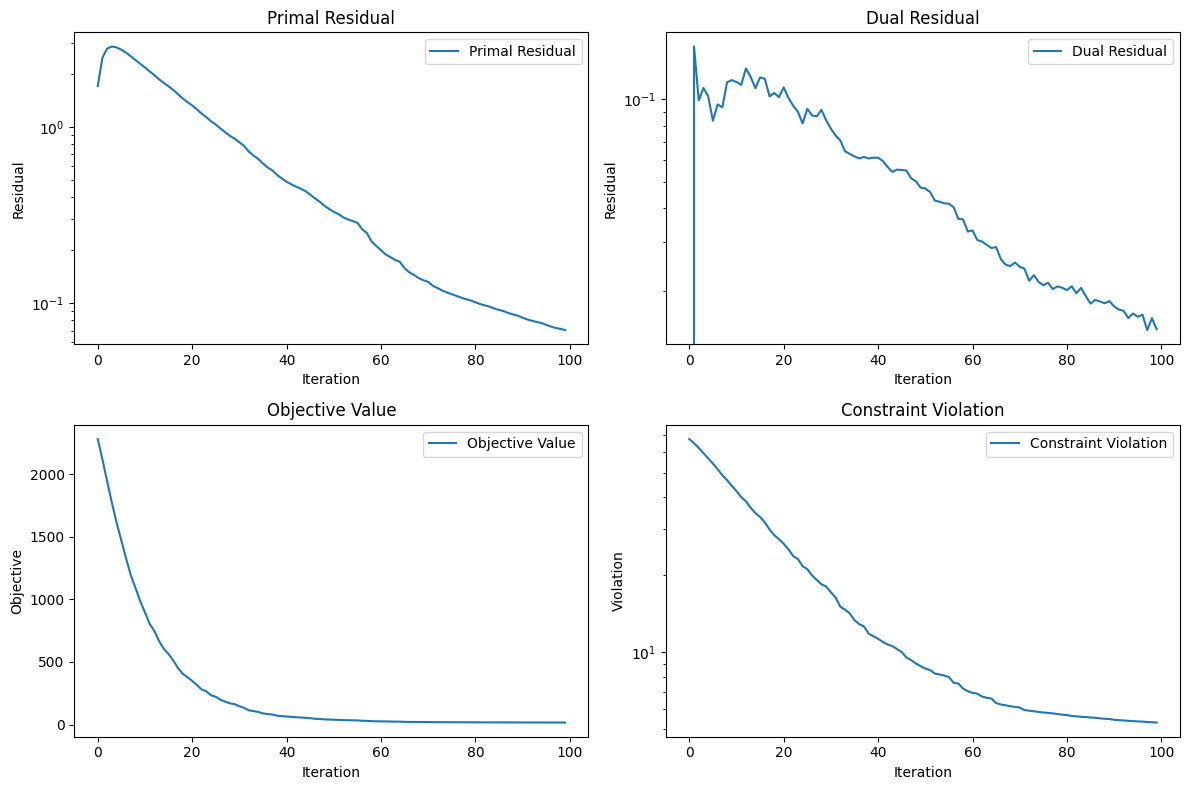

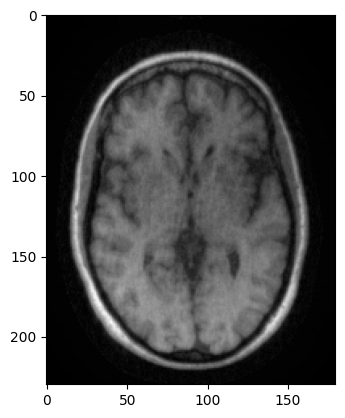

In [80]:
# FP8 simulated arithmetic helper functions
def fp8_add(a, b, fp8_format):
    # Convert inputs to FP8 if not already (assume they are already FP8 for simplicity).
    # Perform addition in double precision
    c = a + b
    # Quantize result back to FP8
    c_fp8 = to_fp8(c, fp8_format)
    return c_fp8

def fp8_sub(a, b, fp8_format):
    c = a - b
    c_fp8 = to_fp8(c, fp8_format)
    return c_fp8

def fp8_roll(x, shift, axis, fp8_format):
    # Roll in double precision then quantize
    xr = np.roll(x, shift, axis=axis)
    xr_fp8 = to_fp8(xr, fp8_format)
    return xr_fp8

def to_fp8(x, format):
    fp8_real = gfloat.round_ndarray(format, x.real)
    fp8_imag = gfloat.round_ndarray(format, x.imag)
    fp8_complex = fp8_real + 1j * fp8_imag
    return fp8_complex

def to_fp16(x):
    real_part = x.real.astype(np.float16)
    imag_part = x.imag.astype(np.float16)
    return real_part + 1j * imag_part

def fft2c(x):
    return np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(x, axes=(-2,-1)), norm='ortho'), axes=(-2,-1))

def ifft2c(x):
    return np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(x, axes=(-2,-1)), norm='ortho'), axes=(-2,-1))

#---------- 3. fp8 candidate (no difference)-------
def forward_A(x, mps, mask, fp8_format=None):
    # Keep these in higher precision (FP16/FP32)
    coil_imgs = mps * x[np.newaxis, ...]
    coil_kspace = fft2c(coil_imgs)
    coil_kspace_masked = coil_kspace * mask
    return to_fp8(coil_kspace_masked, fp8_format)

def adjoint_A(y, mps, mask, fp8_format=None):
    # Keep in higher precision
    y_filled = y * mask
    coil_imgs = ifft2c(y_filled)
    x = np.sum(coil_imgs * np.conjugate(mps), axis=0)
    return to_fp8(x, fp8_format)

def forward_G(x, fp8_format):
    # Emulate FP8 operations:
    # Steps:
    # 1. Convert x to FP8
    x_fp8 = to_fp8(x, fp8_format)
    h, w = x.shape

    # Compute Gx in FP8:
    # Gx[0,i,j] = x[i, j+1] - x[i,j]
    # Gx[1,i,j] = x[i+1, j] - x[i,j]

    # Roll indices in FP8:
    rolled_w_fp8 = fp8_roll(x_fp8, -1, 1, fp8_format)  # x[:, j+1]
    rolled_h_fp8 = fp8_roll(x_fp8, -1, 0, fp8_format)  # x[i+1, :]

    # Subtractions in FP8:
    gx0_fp8 = fp8_sub(rolled_w_fp8, x_fp8, fp8_format)
    gx1_fp8 = fp8_sub(rolled_h_fp8, x_fp8, fp8_format)

    # Stack results:
    Gx_fp8 = np.stack([gx0_fp8, gx1_fp8], axis=0)

    return Gx_fp8

def adjoint_G(u, fp8_format):
    # u is (2, h, w)
    # Emulate FP8 operations again:
    # Convert u to FP8
    u_fp8 = to_fp8(u, fp8_format)
    ux_fp8 = u_fp8[0]
    uy_fp8 = u_fp8[1]

    h, w = ux_fp8.shape

    # For adjoint:
    # G^H(u)[i,j] = (u[0,i,j] - u[0,i,j-1]) + (u[1,i,j] - u[1,i-1,j])
    # Carefully do these in FP8.

    # Roll back:
    ux_roll_fp8 = fp8_roll(ux_fp8, 1, 1, fp8_format) # u[0,i,j-1]
    uy_roll_fp8 = fp8_roll(uy_fp8, 1, 0, fp8_format) # u[1,i-1,j]

    # Perform subtractions in FP8:
    diff_x_fp8 = fp8_sub(ux_fp8, ux_roll_fp8, fp8_format)
    diff_y_fp8 = fp8_sub(uy_fp8, uy_roll_fp8, fp8_format)

    # Add them together in FP8:
    x_grad_fp8 = fp8_add(diff_x_fp8, diff_y_fp8, fp8_format)

    return x_grad_fp8

def prox_fstar(u_f, sigma, y, fp8_format=None):
    # Keep in FP16/FP32
    #----------4. candidate for fp8 (no difference)----------
    return (u_f - sigma * y) / (1 + sigma)
    # u_f_fp8 = to_fp8(u_f, fp8_format)
    # y_fp8 = to_fp8(y, fp8_format)
    # return to_fp8((u_f_fp8 - sigma * y_fp8) / (1 + sigma), fp8_format)


def prox_gstar(u_g, lam, fp8_format):
    # Elementwise projection in FP8:
    # Convert to FP8 if not already
    #------------5. candidate for fp8 (resulted in negative values for fp8 intermediates)------------
    u_g_fp8 = to_fp8(u_g, fp8_format)
    mag = np.sqrt(np.sum(np.abs(u_g_fp8)**2, axis=0))
    scale = np.maximum(1.0, mag / lam)
    scale = scale[np.newaxis, :, :]

    # scale the FP8 array:
    scaled_u_g = u_g_fp8 / scale
    scaled_u_g_fp8 = to_fp8(scaled_u_g, fp8_format)

    #------ for intermediate fp8----------
    # mag_fp8 = to_fp8(np.sqrt(np.sum(np.abs(u_g_fp8)**2, axis=0)), fp8_format)
    # scale_fp8 = to_fp8(np.maximum(1.0, mag_fp8 / lam), fp8_format)
    # scale_fp8 = scale_fp8[np.newaxis, :, :]
    # scaled_u_g_fp8 = to_fp8(u_g_fp8 / scale_fp8, fp8_format)

    return scaled_u_g_fp8

def pdhg_recon(y, mps, lam, max_iter=100, tol=1e-6, fp8_format=None):
    num_coils, h, w = mps.shape
    mask = (np.abs(y) > 0).any(axis=0)
    mask = mask[np.newaxis, ...] 

    x = np.zeros((h, w), dtype=np.complex128)
    x_bar = x.copy()

    u_f = np.zeros_like(y)
    u_g = np.zeros((2, h, w), dtype=np.complex128)

    sigma = 1.0
    tau = 0.05
    theta = 1.0

    # lists to store convergence metrics
    primal_residuals = []
    dual_residuals = []
    objective_values = []
    constraint_violations = []

    for i in range(max_iter):
        x_old = x.copy()
        u_g_old = u_g.copy()

        # Dual update f:
        u_f = prox_fstar(u_f + sigma * forward_A(x_bar, mps, mask, fp8_format), sigma, y, fp8_format)

        # Dual update g in FP8:
        Gx_bar_fp8 = forward_G(x_bar, fp8_format)
        u_g_fp8 = to_fp8(u_g, fp8_format)
        # u_g <- u_g + sigma*Gx_bar in FP8
        u_g_fp8 = fp8_add(u_g_fp8, sigma * Gx_bar_fp8, fp8_format)
        # prox_gstar in FP8
        u_g_fp8 = prox_gstar(u_g_fp8, lam, fp8_format)
        u_g = u_g_fp8  # now u_g is in FP8 quantized form

        # Primal update: #--------2. fp8 candidate (no difference)---------
        grad_data = adjoint_A(u_f, mps, mask, fp8_format)  # FP16/FP32
        grad_tv_fp8 = adjoint_G(u_g, fp8_format)
        grad_tv = grad_tv_fp8  

        #--------1. fp8 candidate (big difference)--------
        x = x - tau * (grad_data + grad_tv)
        x_bar = x + theta * (x - x_old)

        # calculate convergence metrics and append to lists
        primal_residual = np.linalg.norm(x - x_old)
        dual_residual = np.linalg.norm(u_g - u_g_old)
        constraint_violation = np.linalg.norm(forward_A(x, mps, mask, fp8_format) - y)
        total_variation = np.sum(np.sqrt(np.sum(np.abs(forward_G(x, fp8_format))**2, axis=0)))
        objective_value = 0.5 * np.linalg.norm(forward_A(x, mps, mask, fp8_format) - y)**2 + lam * total_variation

        primal_residuals.append(primal_residual)
        dual_residuals.append(dual_residual)
        objective_values.append(objective_value)
        constraint_violations.append(constraint_violation)

        # convergence check
        if primal_residual < tol:
            print(f"Converged at iteration {i}")
            break

    return x, primal_residuals, dual_residuals, objective_values, constraint_violations



lam = 1e-3
# # Run reconstruction
# x_recon = pdhg_recon(ksp, mps, lam, max_iter=100, tol=1e-7, fp8_format=format_info_binary32)
# x_recon_fp8 = pdhg_recon(ksp, mps, lam, max_iter=100, tol=1e-7, fp8_format=format_info_ocp_e5m2)
# plt.subplot(121)
# plt.imshow(np.flip(np.abs(x_recon)), cmap='gray')
# plt.title("fp32")
# plt.subplot(122)
# plt.imshow(np.flip(np.abs(x_recon_fp8)), cmap='gray')
# plt.title("fp8")
# plt.show()

# print(np.allclose(x_recon, x_recon_fp8))


# Run PDHG reconstruction
x, primal_residuals, dual_residuals, objective_values, constraint_violations = pdhg_recon(
    ksp, mps, lam, max_iter=100, tol=1e-6, fp8_format=format_info_ocp_e5m2
)

# Plot convergence metrics
iterations = range(len(primal_residuals))

plt.figure(figsize=(12, 8))

# Primal residual
plt.subplot(2, 2, 1)
plt.plot(iterations, primal_residuals, label='Primal Residual')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.title('Primal Residual')
plt.legend()

# Dual residual
plt.subplot(2, 2, 2)
plt.plot(iterations, dual_residuals, label='Dual Residual')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Residual')
plt.title('Dual Residual')
plt.legend()

# Objective value
plt.subplot(2, 2, 3)
plt.plot(iterations, objective_values, label='Objective Value')
plt.xlabel('Iteration')
plt.ylabel('Objective')
plt.title('Objective Value')
plt.legend()

# Constraint violation
plt.subplot(2, 2, 4)
plt.plot(iterations, constraint_violations, label='Constraint Violation')
plt.yscale('log')
plt.xlabel('Iteration')
plt.ylabel('Violation')
plt.title('Constraint Violation')
plt.legend()

plt.tight_layout()
plt.show()


plt.imshow(np.flip(np.abs(x)), cmap='gray')



#### FLOPS and memory usage (not fully complete)

In [83]:
import numpy as np

def calculate_flops_and_memory(image_size, num_coils, num_iterations, precision_bytes):
    """
    Calculate theoretical FLOPS and memory usage/movement for the PDHG solver.

    Parameters:
        image_size (tuple): Dimensions of the image (height, width).
        num_coils (int): Number of coils in the MRI data.
        num_iterations (int): Number of iterations in the solver.
        precision_bytes (dict): Dictionary with bytes per element for FP32, FP16, FP8.
                                Example: {'fp32': 4, 'fp16': 2, 'fp8': 1}
    
    Returns:
        dict: FLOPS and memory movement estimates.
    """
    h, w = image_size
    num_pixels = h * w

    # FLOPS calculation
    flops = {}

    # primal update: x = x - tau * (grad_data + grad_tv)
    primal_update_flops = num_pixels * 2  # one addition, one multiplication per pixel

    # Dual update (forward_A and adjoint_A + prox_gstar)
    # Approximation: forward_A and adjoint_A involve FFT/IFFT and basic operations
    fft_flops_per_coil = 5 * num_pixels * np.log2(num_pixels)
    fft_total_flops = 2 * fft_flops_per_coil * num_coils  # fft + ifft for all coils
    grad_tv_flops = num_pixels * 4  # Two subtractions and two additions per pixel for Gx and Gy
    prox_gstar_flops = num_pixels * 4  # Magnitude, scale, division, projection

    # Total FLOPS per iteration
    total_flops_per_iter = (
        primal_update_flops +
        fft_total_flops +
        grad_tv_flops +
        prox_gstar_flops
    )

    flops["total_per_iter"] = total_flops_per_iter
    flops["total"] = total_flops_per_iter * num_iterations 

    #------- Memory movement------ 
    memory = {}

    # Variables (x, x_bar, u_f, u_g)
    x_memory = num_pixels * precision_bytes["fp32"]
    x_bar_memory = num_pixels * precision_bytes["fp32"]
    u_f_memory = num_coils * num_pixels * precision_bytes["fp8"]
    u_g_memory = 2 * num_pixels * precision_bytes["fp8"]  # Two gradient components

    # FFT/IFFT and k-space operations
    k_space_memory = num_coils * num_pixels * precision_bytes["fp8"]

    # total memory movement per iteration
    reads_writes_per_iter = (
        2 * (x_memory + x_bar_memory) +  # x and x_bar
        2 * u_f_memory +  # u_f read/write
        2 * u_g_memory +  # u_g read/write
        4 * k_space_memory  # FFT and adjoint operations
    )

    memory["per_iter"] = reads_writes_per_iter 
    memory["total"] = reads_writes_per_iter * num_iterations 

    return {
        "FLOPS": flops,
        "Memory": memory
    }

# Parameters
image_size = (230, 180)
num_coils = 8
num_iterations = 100
precision_bytes = {"fp32": 4, "fp16": 2, "fp8": 1}

results = calculate_flops_and_memory(image_size, num_coils, num_iterations, precision_bytes)
results


{'FLOPS': {'total_per_iter': np.float64(51211280.503771655),
  'total': np.float64(5121128050.377166)},
 'Memory': {'per_iter': 2815200, 'total': 281520000}}